In [1]:
!pip install mysql-connector-python


    100% |████████████████████████████████| 8.1MB 4.0MB/s 


# Homework №1
## Group project name: Scopus

In [0]:
import networkx as nx
import mysql.connector
import matplotlib.pyplot as plt
import random
import numpy as np

In [0]:
mydb = mysql.connector.connect(
  host="articlesgrap.cxqhtfp4sprs.eu-central-1.rds.amazonaws.com",
  user="wizard",
  passwd="12345678",
  database="TheData"
)

### Download coauthorship graph from db for certain period

In [0]:
def getAutGraph(by, fy):
    '''get co-authors between years by and fy'''
    mycursor = mydb.cursor()
    sql = "SELECT a.auid, b.auid, count(b.auid) as weight FROM TheData.isAuthor as a join TheData.isAuthor as b on a.artid=b.artid join TheData.Articles as c on a.artid=c.id where c.year between %s and %s and a.auid <> b.auid group by a.auid, b.auid order by a.auid desc;"
    val = (by, fy)
    mycursor.execute(sql, val)
    myresult = mycursor.fetchall()
    mycursor.close()
    return myresult
  
  

In [0]:
def make_nx_g(edges):
    g = nx.Graph((x, y, {'weight': v}) for x, y, v in edges)
    return g

In [0]:
default_g = make_nx_g(getAutGraph(2012, 2012))
nx.set_node_attributes(default_g, {i: str(i) for i in default_g.nodes}, 'name')

### Large graph scaling

Since our graph is heavy for visualisation we have to resort to graph sampling.

In [0]:
class SRW():
    def __init__(self):
        self.growth_size = 2
        self.T = 100 
        self.fly_back_prob = 0.15

    def random_walk_sampling_with_fly_back(self,complete_graph, nodes_to_sample, fly_back_prob):
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, ordering='default', label_attribute='name')
        named = nx.convert_node_labels_to_integers(complete_graph, 0, ordering='default', label_attribute='name')
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.node[n]['id'] = n

        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample

        index_of_first_random_node = random.randint(0, nr_nodes-1)
        sampled_graph = nx.Graph()

        sampled_graph.add_node(complete_graph.node[index_of_first_random_node]['id'])

        iteration = 1
        edges_before_t_iter = 0
        curr_node = index_of_first_random_node
        while sampled_graph.number_of_nodes() != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            sampled_graph.add_node(chosen_node)
            sampled_graph.add_edge(curr_node, chosen_node, weight=complete_graph[curr_node][chosen_node]['weight'])
            choice = np.random.choice(['prev','neigh'], 1, p=[fly_back_prob,1-fly_back_prob])
            if choice == 'neigh':
                curr_node = chosen_node
            iteration=iteration+1

            if iteration % self.T == 0:
                if ((sampled_graph.number_of_edges() - edges_before_t_iter) < self.growth_size):
                    curr_node = random.randint(0, nr_nodes-1)
                    print("Choosing another random node to continue random walk ")
                    
                edges_before_t_iter = sampled_graph.number_of_edges()
        
        nx.set_node_attributes(sampled_graph, {i: complete_graph.nodes(data=True)[i]['name'] for i in sampled_graph}, 'name')
        
        return sampled_graph

In [0]:
srw = SRW()

g = srw.random_walk_sampling_with_fly_back(default_g, 70, .8)


w = nx.get_edge_attributes(g,'weight')

w_coeff = 3
w_line = [w[i] * w_coeff for i in g.edges()]

## Visualise

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


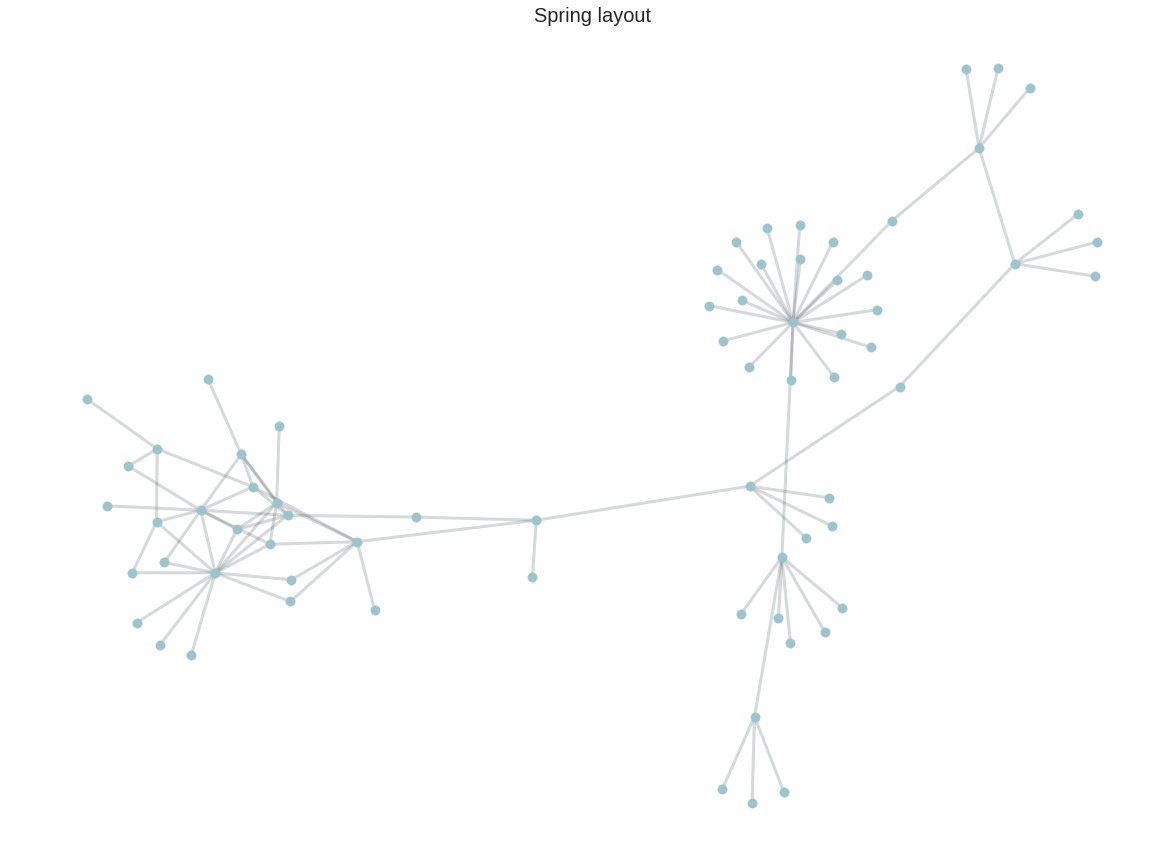

In [10]:
l_out = nx.spring_layout(g)

plt.figure(figsize=(20, 15))
plt.title('Spring layout', fontsize=20)
nx.draw_networkx_edges(g, l_out, width=w_line, edge_color='#4C5B5C', alpha=0.23)
nx.draw_networkx_nodes(g, l_out, node_color='#9BC4CB', node_size = 90)
plt.axis('off')
plt.show()

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


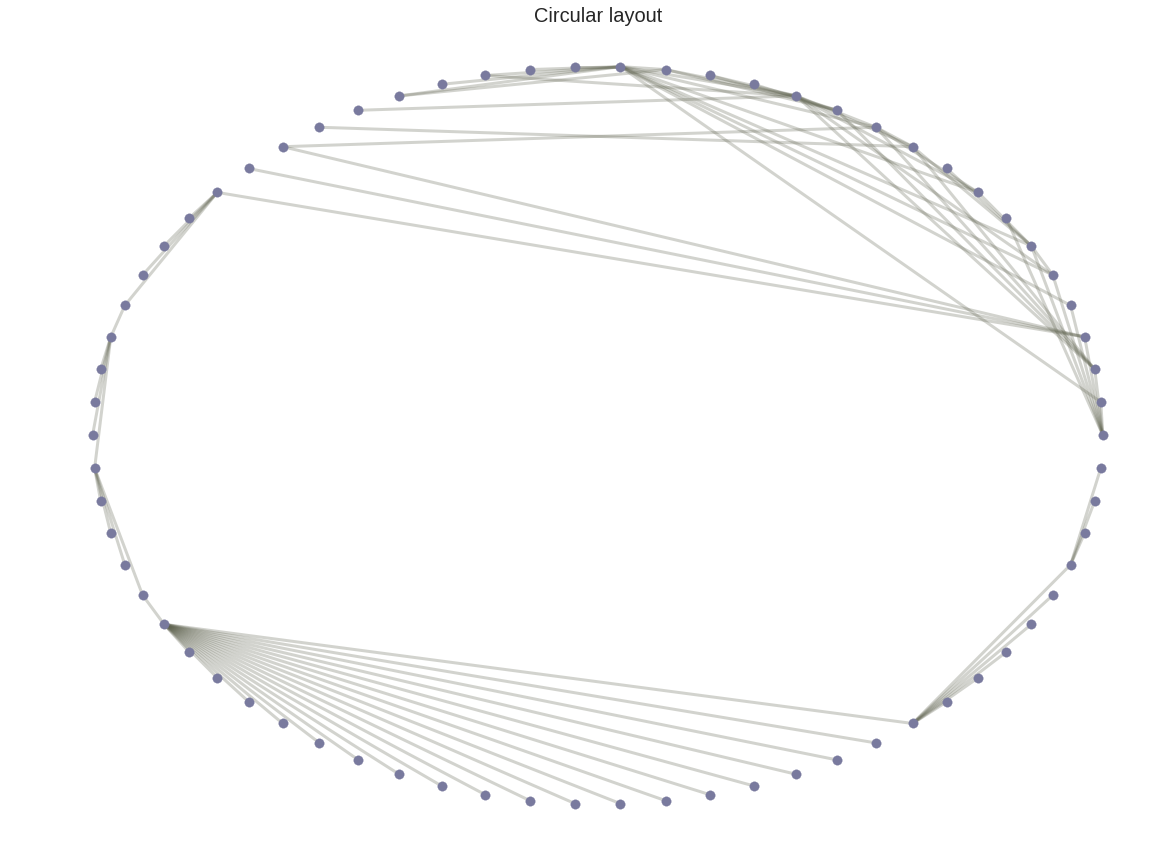

In [11]:
l_out = nx.circular_layout(g)

plt.figure(figsize=(20, 15))
plt.title('Circular layout', fontsize=20)
nx.draw_networkx_edges(g, l_out, width=w_line, edge_color='#5F634F', alpha=0.28)
nx.draw_networkx_nodes(g, l_out, node_color='#797A9E', node_size = 90)
plt.axis('off')
plt.show()


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


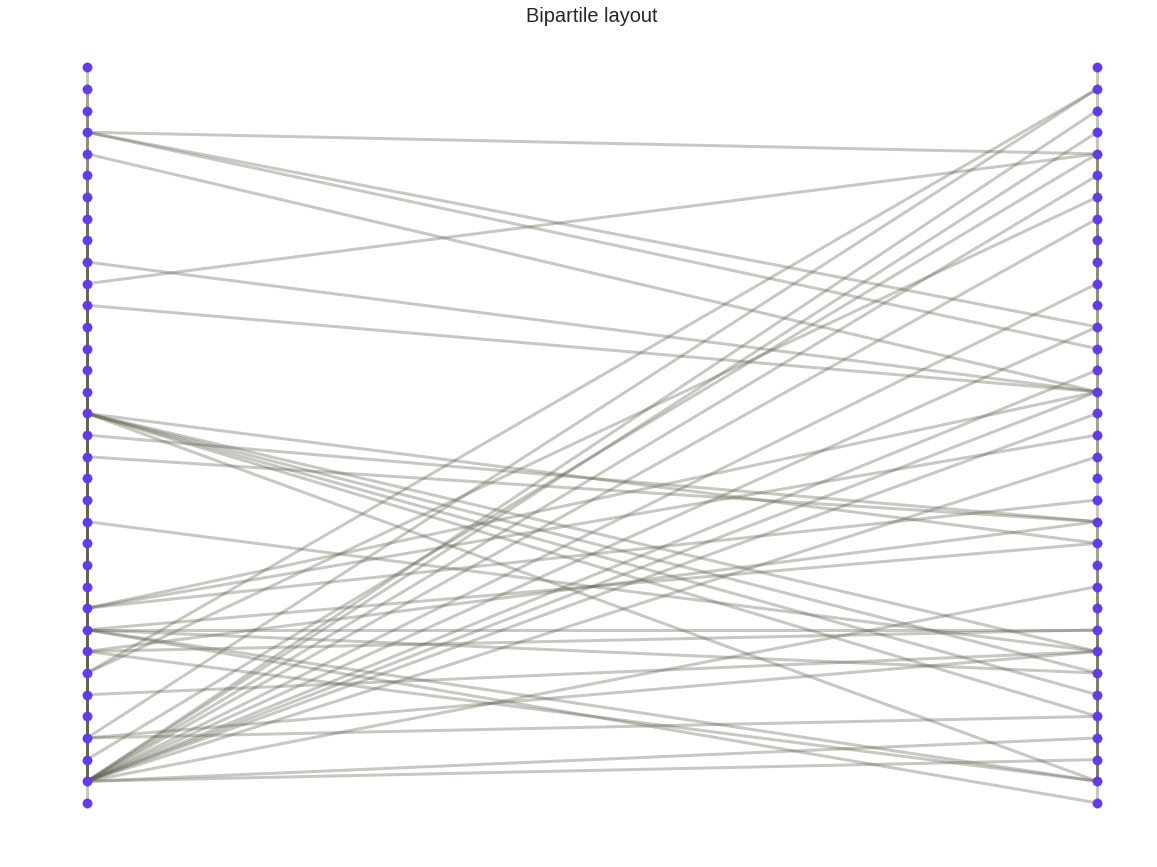

In [12]:
import numpy as np

l_out = nx.drawing.layout.bipartite_layout(g, np.random.choice(g.nodes(), len(g.nodes()) // 2, replace=False))

plt.figure(figsize=(20, 15))
plt.title('Bipartile layout', fontsize=20)
nx.draw_networkx_edges(g, l_out, width=w_line, edge_color='#5F634F', alpha=0.35)
nx.draw_networkx_nodes(g, l_out, node_color='#623CEA', node_size = 90)
plt.axis('off')
plt.show()

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


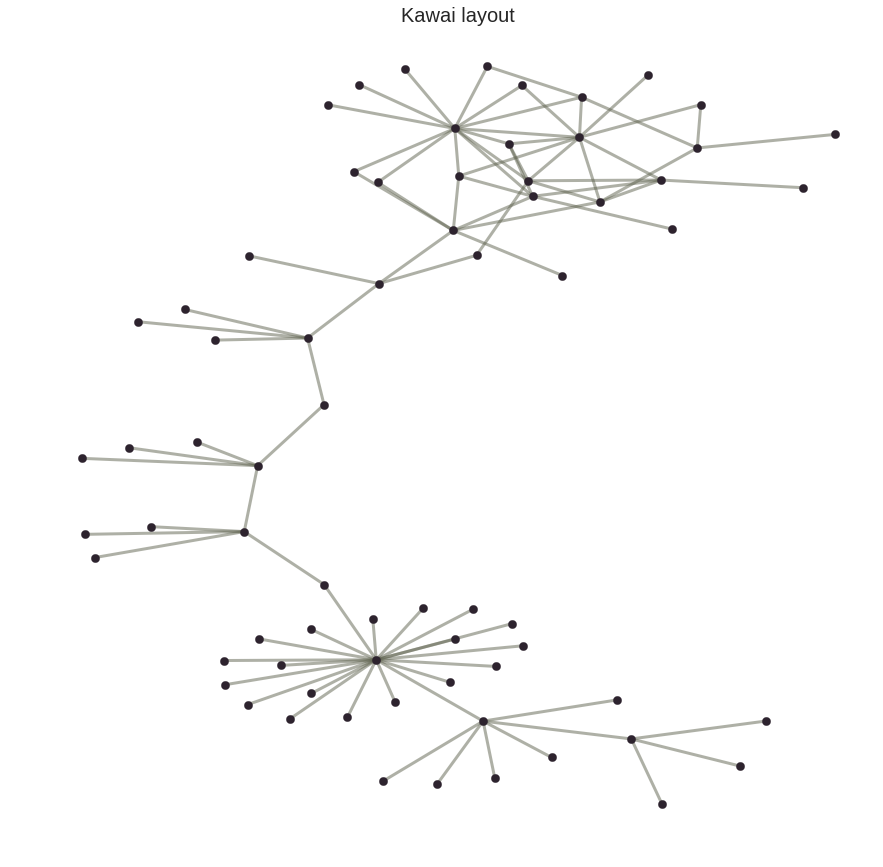

In [13]:
l_out = nx.kamada_kawai_layout(g)

plt.figure(figsize=(15, 15))
plt.title('Kawai layout', fontsize=20)
nx.draw_networkx_edges(g, l_out, width=w_line, edge_color='#5F634F', alpha=0.5)
nx.draw_networkx_nodes(g, l_out, node_color='#2D232E', node_size = 70)
plt.axis('off')
plt.show()


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


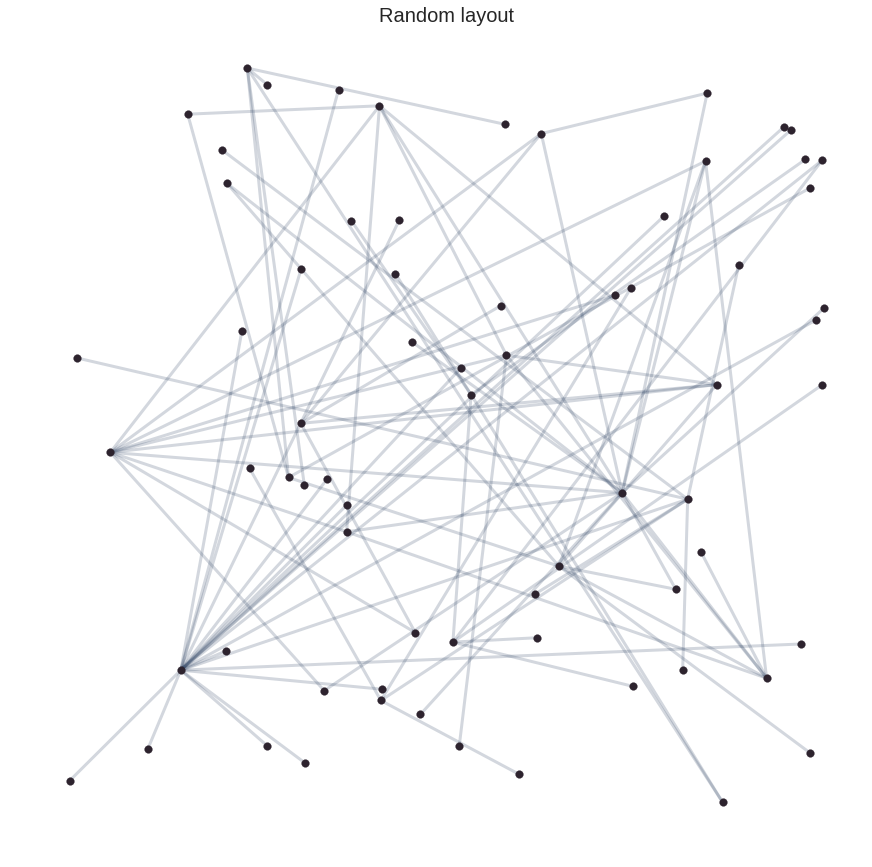

In [14]:
l_out = nx.random_layout(g)

plt.figure(figsize=(15, 15))
plt.title('Random layout', fontsize=20)
nx.draw_networkx_edges(g, l_out, width=w_line, edge_color='#23395B', alpha=0.2)
nx.draw_networkx_nodes(g, l_out, node_color='#2D232E', node_size = 60)
plt.axis('off')
plt.show()

## Graph Metrics

In [15]:
print('Graph Density: ', nx.density(g))
print('Graph Diameter: ', nx.diameter(g))
print('Graph Radius: ', nx.radius(g))
print('Graph Average Degree: ', np.mean(g.degree(), axis=0)[1])

Graph Density:  0.036853002070393374
Graph Diameter:  13
Graph Radius:  7
Graph Average Degree:  2.5428571428571427


### Degree distribution

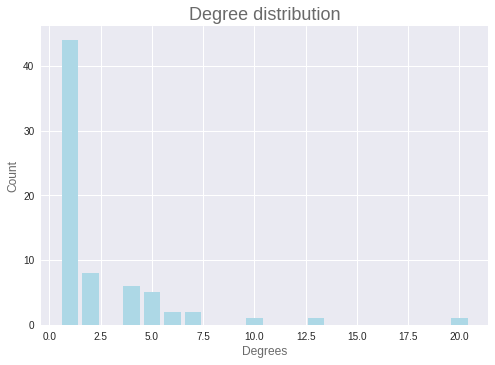

In [16]:
from collections import Counter
degrees = [degree for (_, degree) in g.degree()]

degree_count = Counter(degrees)
cnt = [degree_count[degree] for degree in degrees]


plt.title("Degree distribution", color='dimgrey', fontsize=18)
plt.bar(degrees, cnt, color='lightblue')
plt.xlabel("Degrees", color="dimgrey", fontsize=12)
plt.ylabel("Count", color="dimgrey", fontsize=12)
plt.show()


## Interesting facts

Let's calculate different centralities on our graph


In [0]:
def draw_centrality(g, centralities, name):
    plt.figure(figsize=(20,15))
    plt.title(name, color="#161B33", fontsize=15)

    c_norm = centralities/np.max(centralities)
    nx.draw_networkx_edges(g, l_out, alpha=0.3)
    nx.draw_networkx_nodes(g, l_out, node_size=c_norm*400, node_color=c_norm, cmap='inferno')
    plt.axis('off')
    plt.show();

    (max_id, max_coef) = max(zip(g.nodes(), centralities), key=lambda x: x[1])
    max_id = g.nodes(data=True)[max_id]['name']
    print('Max node', max_id, max_coef)

l_out = nx.spring_layout(g)


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


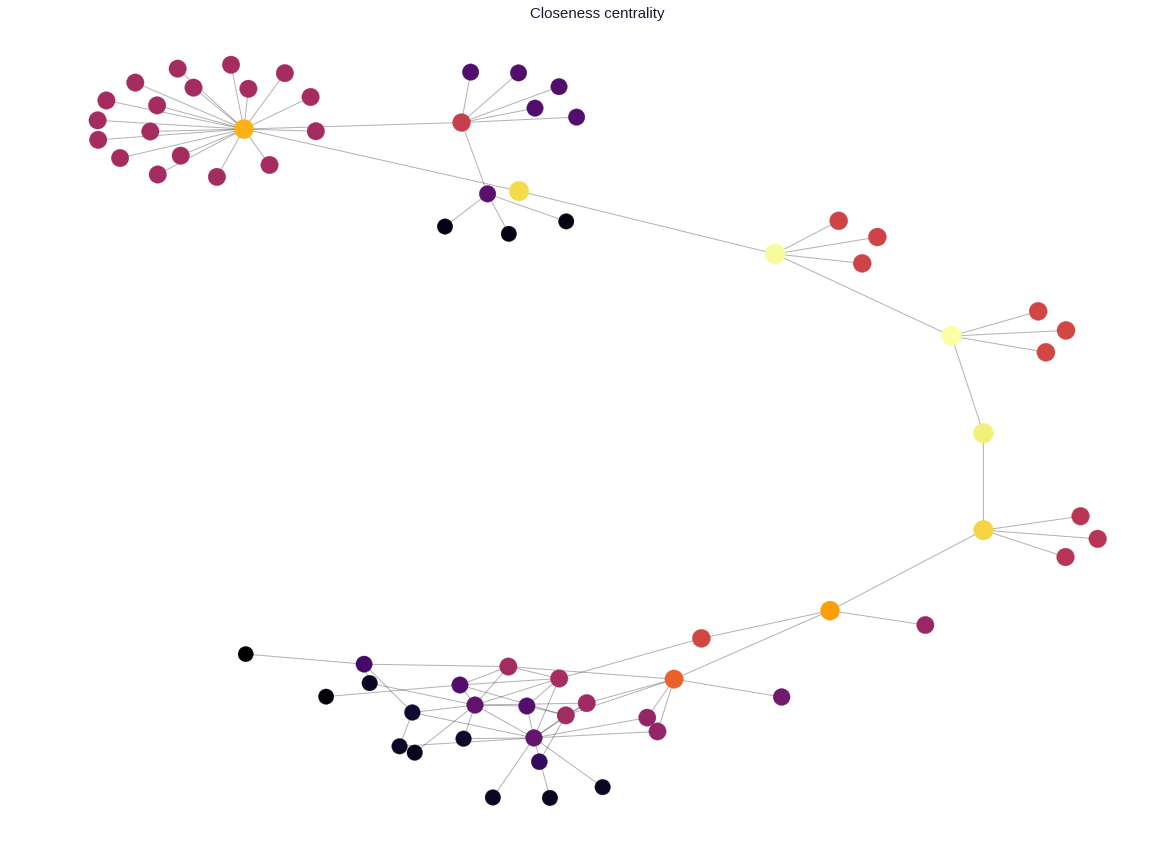

Max node 57202558242 0.2247557003257329


In [19]:
closeness = np.array([nx.closeness_centrality(g)[node] for node in g])

draw_centrality(g, closeness, 'Closeness centrality')

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


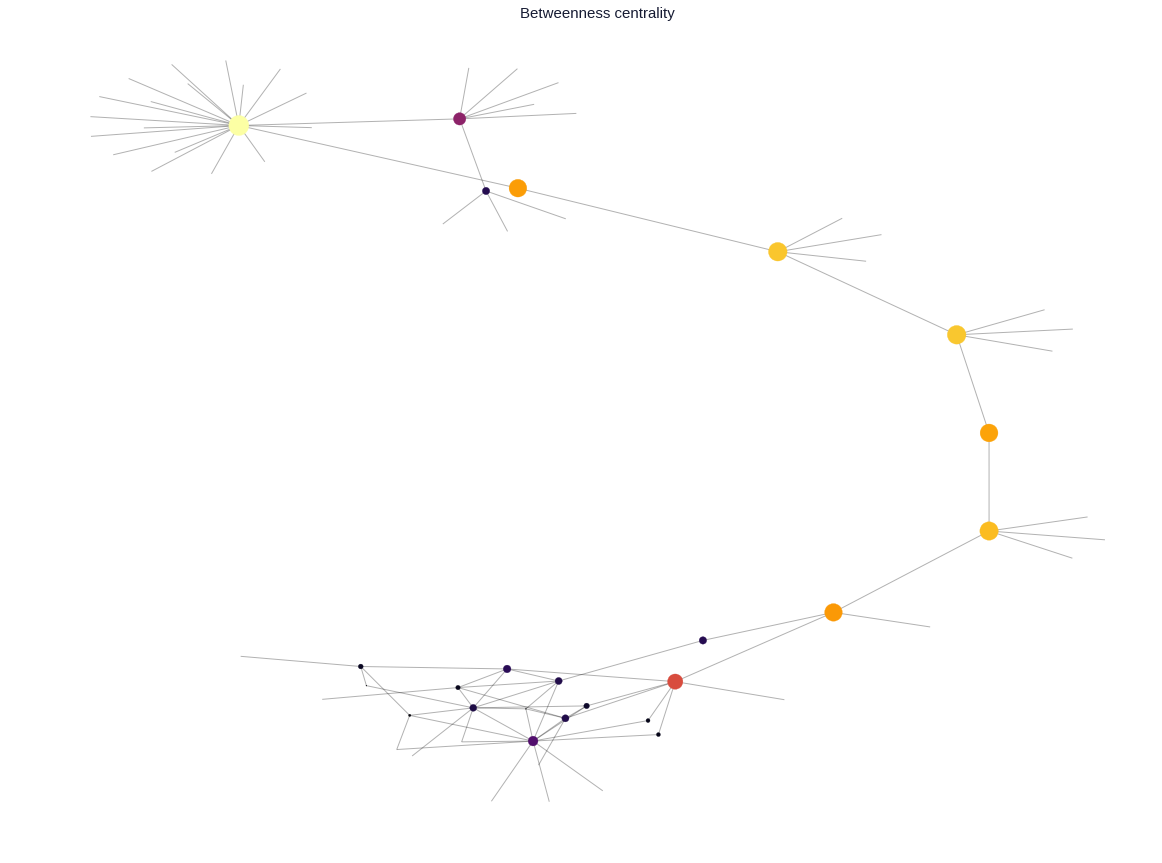

Max node 57202563326 0.6312872975277067


In [20]:
betweenness = np.array([nx.betweenness_centrality(g)[node] for node in g])

draw_centrality(g, betweenness, 'Betweenness centrality')

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


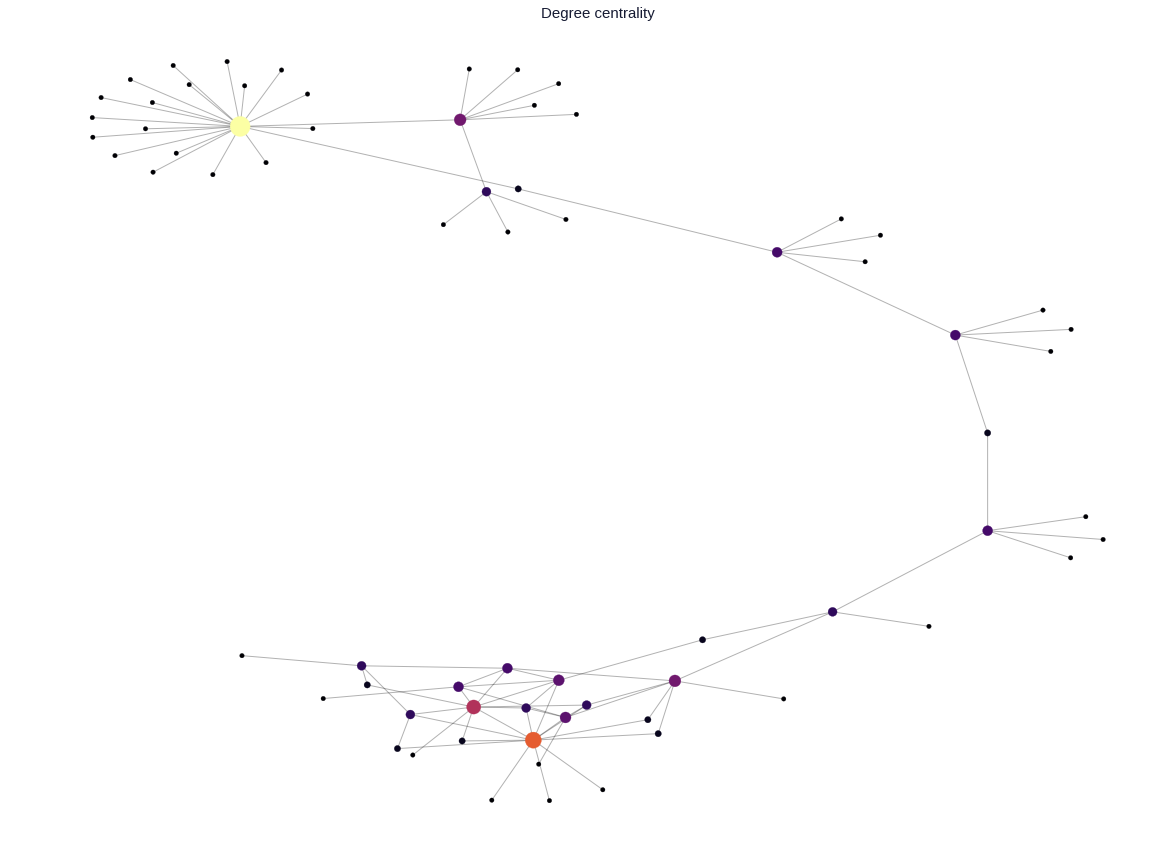

Max node 57202563326 0.2898550724637681


In [21]:
degree_c = np.array([nx.degree_centrality(g)[node] for node in g])

draw_centrality(g, degree_c, 'Degree centrality')

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


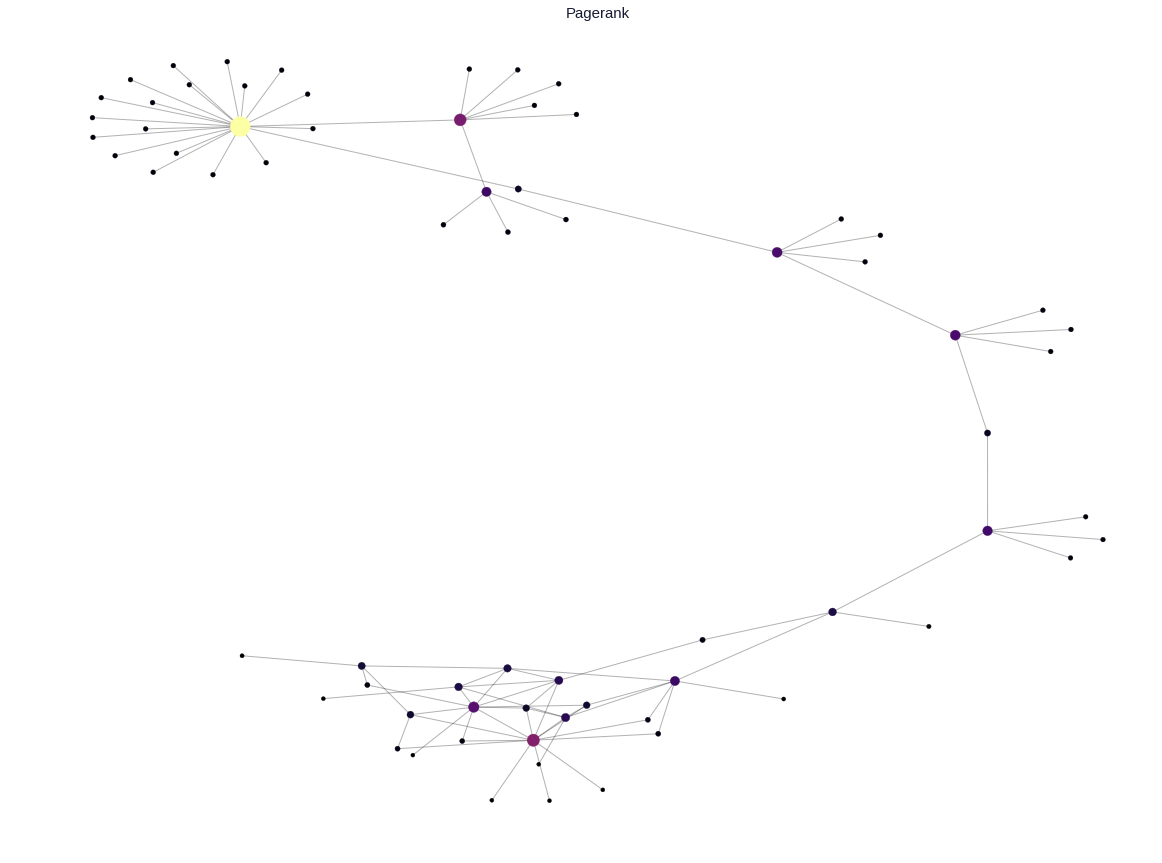

Max node 57202563326 0.13283555233933564


In [22]:
pagerank = np.array([nx.pagerank(g)[node] for node in g])

draw_centrality(g, pagerank, 'Pagerank')

As we can see, node 57202563326 has highest degree and betweenness centralities. According to database this author name is 	Karpe F. He had only one work in 2012 with	"Novel loci for adiponectin levels and their influence on type 2 diabetes and metabolic traits: A multi-ethnic meta-analysis of 45,891 individuals". This research had more than 200 contributors(authors) so no wonder that centralities consider him important. The second author mentioned in closeness centrality Meisinger C.(57202558242) also participated in this research.

## Community_detection

Since we are working with graph sample, it is important to find a method to recover original links between authors or to recover **article cliques**. Community detection algorithms are best suited for this task as they are able to predict the likelihood of clique emergence.

In [0]:
from networkx.algorithms.community import *
import community

In [24]:
l_out = nx.spring_layout(g)
color = ['#D4E4BC', '#5F634F', '#EE6352', '#E574BC', '#D90368', '#EBBAB9', '#23395B', '#484349', '#8AF3FF', '#BEB2C8', '#EEC584', '#772D8B']
partition = community.best_partition(g)

print('Total', len(partition), 'communities')

Total 70 communities


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


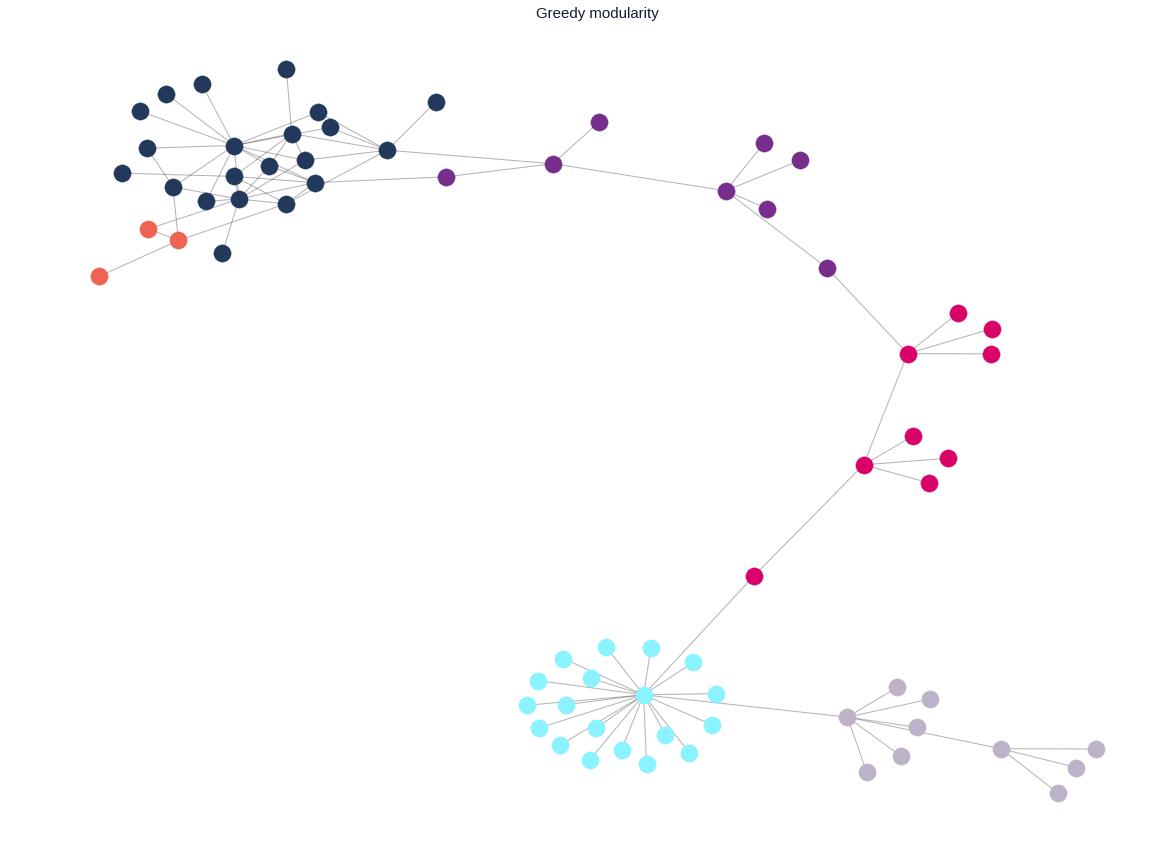

In [25]:
cliques = [i for i in greedy_modularity_communities(g)]


plt.figure(figsize=(20,15))
plt.title('Greedy modularity', color="#161B33", fontsize=15)

nx.draw_networkx_edges(g, l_out, alpha=0.3)
nx.draw_networkx_nodes(g, l_out, alpha=0.3, node_size=70)

#col_idx = 0

for clique in cliques:
  nx.draw_networkx_nodes(clique, l_out, nodelist=clique, node_color=np.random.choice(color), node_size = 300)
  #col_idx += 1
  #nx.draw_networkx_edges(clique, l_out)

#for i in range(len(list(async_com))):
  #  nx.draw_networkx_nodes(list(async_com[i]), pos, nodelist=list(async_com[i]), node_color=color[i], node_size=150)

plt.axis('off')
plt.show()



Label prop found 6


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


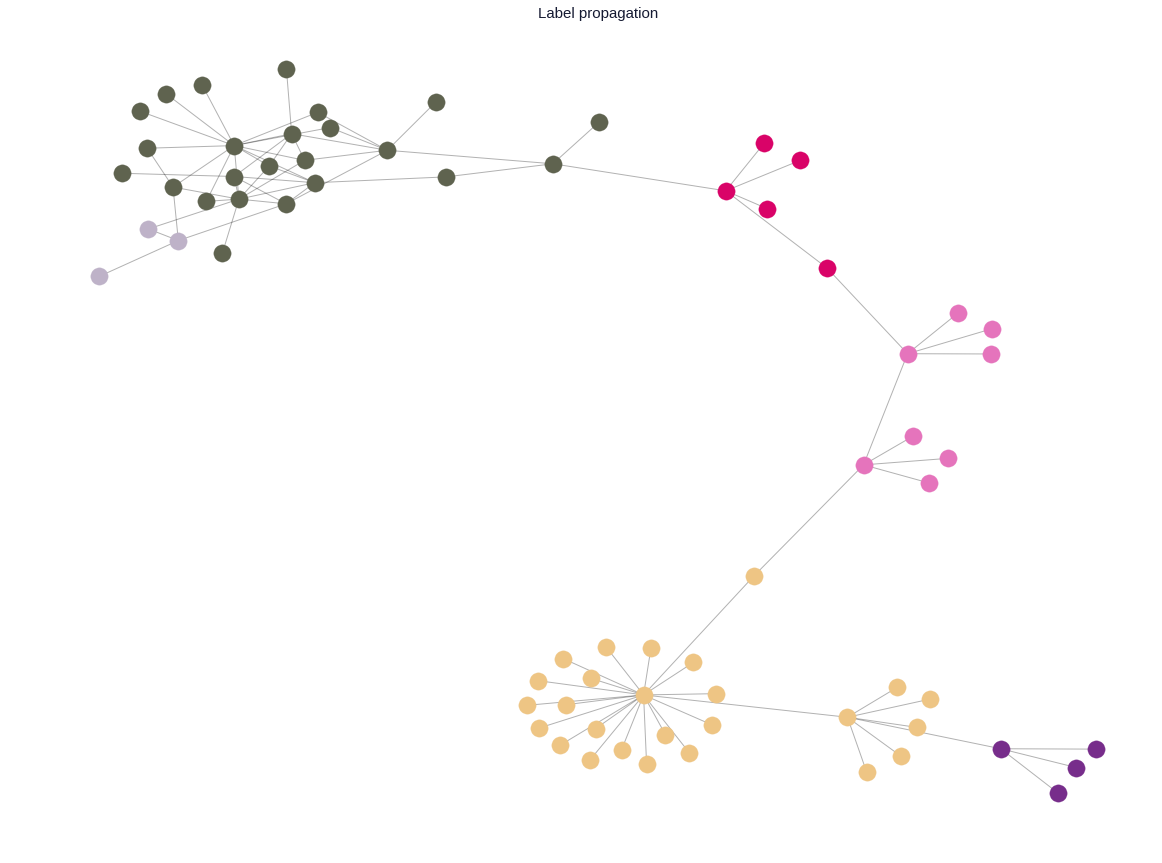

In [26]:
cliques = [i for i in label_propagation_communities(g)]

print('Label prop found', len(cliques))


plt.figure(figsize=(20,15))
plt.title('Label propagation', color="#161B33", fontsize=15)

nx.draw_networkx_edges(g, l_out, alpha=0.3)
nx.draw_networkx_nodes(g, l_out, alpha=0.3, node_size=70)

for clique in cliques:
  nx.draw_networkx_nodes(clique, l_out, nodelist=clique, node_color = np.random.choice(color), node_size = 300)


plt.axis('off')
plt.show()



/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


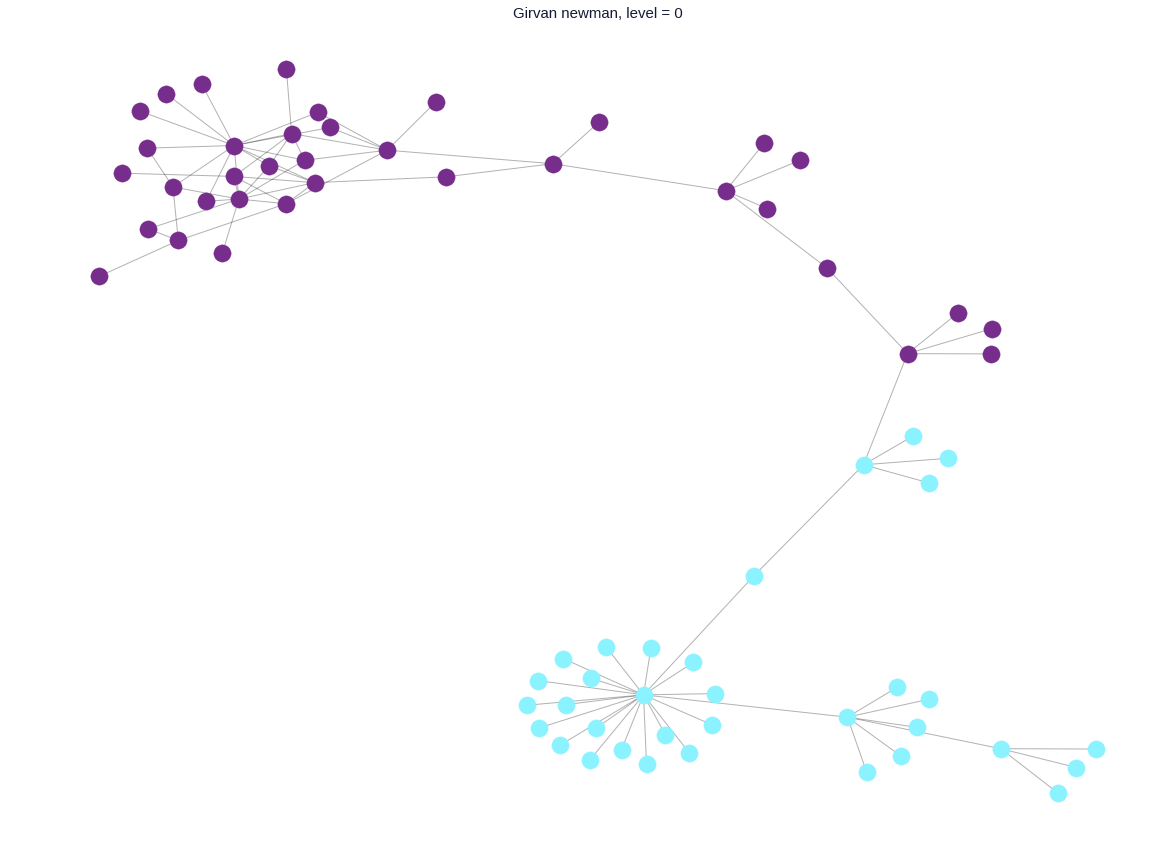

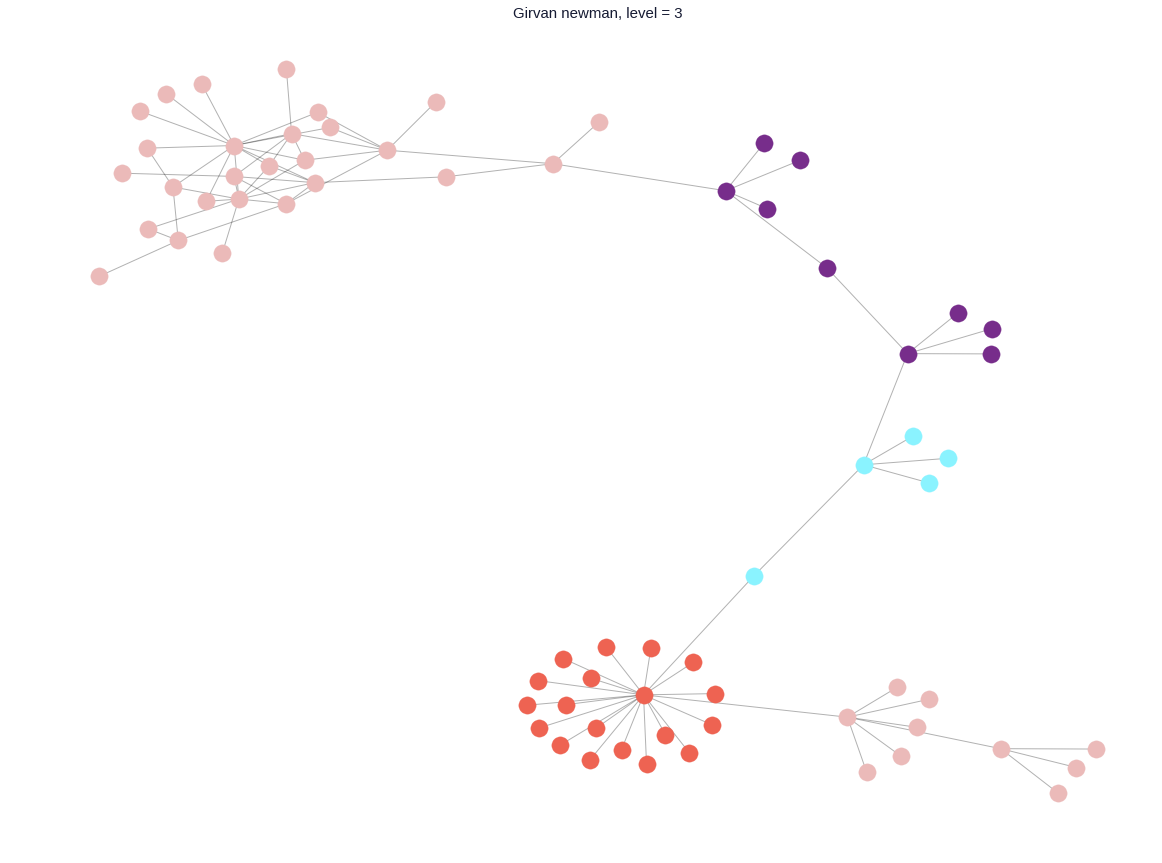

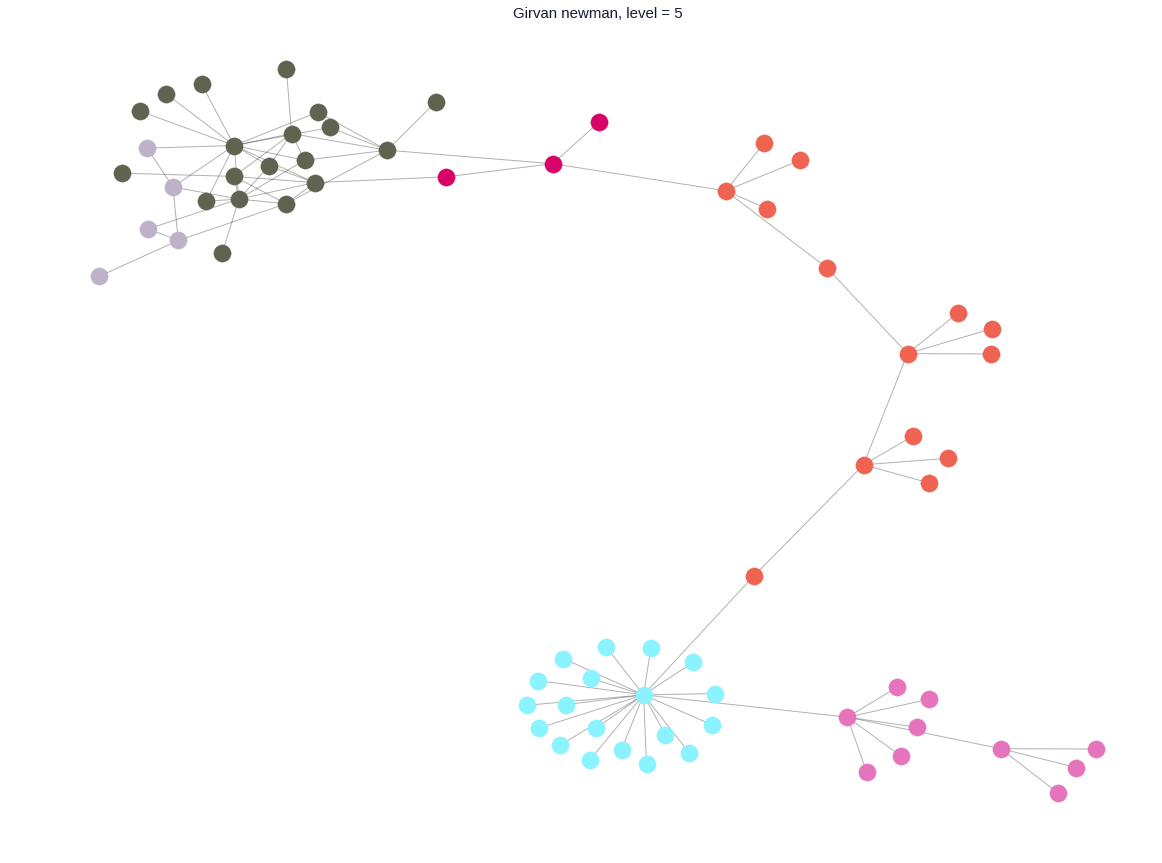

In [27]:
levels = [i for i in girvan_newman(g)]

draw_levels = [0, 3, 5]

for level in draw_levels:
    cliques = levels[level]
    
    plt.figure(figsize=(20,15))
    plt.title('Girvan newman, level = '+str(level), color="#161B33", fontsize=15)

    nx.draw_networkx_edges(g, l_out, alpha=0.3)
    nx.draw_networkx_nodes(g, l_out, alpha=0.3, node_size=70)

    for clique in cliques:
      nx.draw_networkx_nodes(clique, l_out, nodelist=clique, node_color = np.random.choice(color), node_size = 300)


    plt.axis('off')
    plt.show()


Since original connected component consisted of multiple cliques, visually we can easily tell where are article clusters should be located. Unfortunately, community detection algorithms are having difficulties at this task. The best result can be obtained by applying Girvan newman algorithm at level 3 threshold. This method utilizes graph centralities which allows to detect the most influencial nodes or in our case article cluster center. Other methods have relatively equal in quality results. 